In [74]:
import numpy as np
import matplotlib.pyplot as plt
import open3d
import math
import itertools

In the function below we test out different open3d filteration approaches. **Note**, I have already tested that we can convert ros point clouds to open3d point clouds and then convert them back for the tracking lib.

Point cloud filtering is based on - (https://betterprogramming.pub/point-cloud-filtering-in-python-e8a06bbbcee5).

In [91]:
"""
Applies noise reduction and other filteres to an open3d PointCloud and 
returns it. 
"""
def filter_point_cloud(open3d_cloud : open3d.geometry.PointCloud) -> open3d.geometry.PointCloud:
    
    # Pass through filter to reduce noise. Needs to be tweaked for velodyne.
    # Only accept z points between min and max.
    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [-2.0,0]]
    bounding_box_points = list(itertools.product(*bounds))
    bounding_box = open3d.geometry.AxisAlignedBoundingBox.create_from_points(
        open3d.utility.Vector3dVector(bounding_box_points)) # Create bounding box object.
    
    # Crop the point cloud using the bounding box.
    pcd_cropped = open3d_cloud.crop(bounding_box)
    
    # Apply radius outlier removal that removes all points that 
    # don't have a specific number of points around it. 
    pcd_rad, ind_rad = pcd_cropped.remove_radius_outlier(nb_points=200, radius=0.05)
    outlier_rad_pcd = pcd_cropped.select_by_index(ind_rad, invert=True)
    
    # Apply statistical outlier removal filter.
    # This filter removes points that are further away from their
    # neighbours.
    pcd_stat, ind_stat = outlier_rad_pcd.remove_statistical_outlier(nb_neighbors=5, std_ratio=2.0)
    outlier_stat_pcd = outlier_rad_pcd.select_by_index(ind_stat, invert=True)
    
    return outlier_stat_pcd

**Prepare a sample point cloud for testing the filtering process.** The point cloud is put together from a depth camera not velodyne data so this may not be that appropriate for us. The data has been taken from the redwood database (http://redwood-data.org/indoor/dataset.html), and I have followed this tutorial to put it together -  (http://www.open3d.org/docs/0.9.0/tutorial/Basic/rgbd_images/redwood.html#rgbd-redwood).

The point of this is to eventually transition the filteration techniques that work to the velodyne prefilter that we have.

In [76]:
# Read sample point cloud data.
colour_raw = open3d.io.read_image("pointcloud_samples/livingroom1-color/00000.jpg")
depth_raw = open3d.io.read_image("pointcloud_samples/livingroom1-depth-simulated/00000.png")

rgbd_image = open3d.geometry.RGBDImage.create_from_color_and_depth(
    colour_raw, depth_raw)

print(rgbd_image)

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


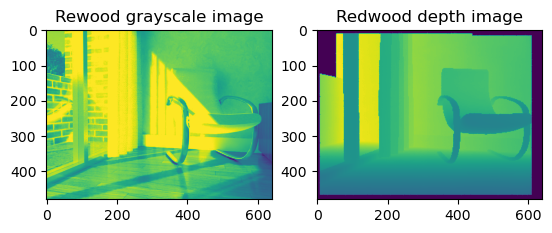

In [77]:
# Display images.
plt.subplot(1,2,1)
plt.title('Rewood grayscale image')
plt.imshow(rgbd_image.color)

plt.subplot(1,2,2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [78]:
# Create the point cloud.
pcd = open3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        open3d.camera.PinholeCameraIntrinsic(
            open3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

In the point cloud example we have created the point cloud from the depth information, but the docs say that this creates an upside down point cloud (not sure why) so they flip the point cloud. I don't think we need to do this with our point clouds.

In [79]:
# Flip point cloud vertically.
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

PointCloud with 267129 points.

In [80]:
open3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: GLX: Failed to create context: GLXBadFBConfig
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [81]:
# Check size of point cloud  since I can't visualise it due to driver issues.
pcd

PointCloud with 267129 points.

**Test filter algorithms**

In [92]:
filter_point_cloud(pcd)

PointCloud with 99 points.